# Noise2Self for Astro

In astronomy datasets, one often acquires many images of the same part of the sky, with different shot, read-out, cosmic ray, and detector noise. Instead of averaging those images, we may train a network to predict one from the other. The resulting output will be a denoised image.

In the simplest case, we have two or more images, and we may use one two predict the other (the Noise2Noise regime). Given more images, we may design a more complicated architecture to take advantage of their multiplicity (instead of merely averaging them to make pairs).

In [1]:
# Clones the github repo such that the notebook can access it
!git clone https://github.com/deepskies/noise2self.git

Cloning into 'noise2self'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 169 (delta 2), reused 6 (delta 2), pack-reused 163
Receiving objects: 100% (169/169), 17.91 MiB | 16.46 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [0]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
%cd noise2self


/content/noise2self


In [0]:
from util import show, plot_images, plot_tensors, plot_grid
from util import clean_two_channel_data, clean_three_channel_data, clamp_data

#Data Quality Check

Import the data

In [0]:
!pip install astropy

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from glob import glob
import os
from collections import defaultdict, Counter
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

In [0]:
fnames = glob("../gdrive/My Drive/Noise2Astro/cutouts_v1/*.gz")
fnames = sorted(fnames)

In [0]:
from astropy.io import fits
print("Number of files: ", len(fnames))

Number of files:  998


In [0]:
galaxies = {}
# Iterates over filenames to parse information
i = 0
for file in fnames:
    _, _, gal_id = os.path.splitext(os.path.basename(file))[0].split('_')
    gal_id = "gal_" + gal_id.replace('.fits', '')
    hdus = fits.open(file)
    imgs = hdus[0].data
    galaxies[gal_id] = imgs
    i += 1
    if i % 50 == 0:
      print(np.round(100*(i + .0)/len(fnames)), "% loaded.")

5.0 % loaded.
10.0 % loaded.
15.0 % loaded.
20.0 % loaded.
25.0 % loaded.
30.0 % loaded.
35.0 % loaded.
40.0 % loaded.
45.0 % loaded.
50.0 % loaded.
55.0 % loaded.
60.0 % loaded.
65.0 % loaded.
70.0 % loaded.
75.0 % loaded.
80.0 % loaded.
85.0 % loaded.
90.0 % loaded.
95.0 % loaded.


In [0]:
# Join image 0 and image 1 from each galaxy
data = np.stack([(galaxies[gal_id][0], galaxies[gal_id][1]) for gal_id in galaxies])

Understand the distrubtions of the images

In [0]:
def mean(x):
  return x.mean(-1).mean(-1)

def mse(x, y):
  return mean((x - y)**2)

(array([  1.,   0., 550., 340.,  59.,  13.,  10.,   9.,   4.,   3.,   1.,
          3.,   0.,   1.,   2.,   0.,   0.,   0.,   1.,   1.]),
 array([-42.57349 , -26.540731, -10.507972,   5.524788,  21.557547,
         37.590305,  53.623066,  69.65582 ,  85.68858 , 101.721344,
        117.754105, 133.78687 , 149.81963 , 165.85239 , 181.88515 ,
        197.9179  , 213.95065 , 229.98341 , 246.01617 , 262.04895 ,
        278.0817  ], dtype=float32),
 <a list of 20 Patch objects>)

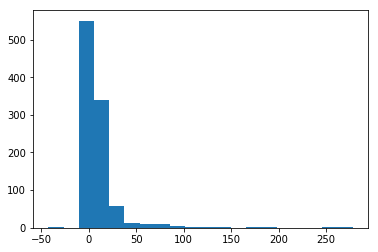

In [0]:
# Distribution of per-image intensity
plt.hist(mean(data[:,0]), bins = 20)
#plt.yscale('log')

Text(0, 0.5, 'noise draw 2')

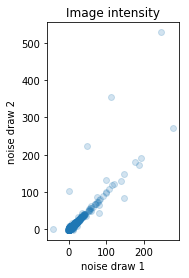

In [0]:
# Distribution of mean before-after

plt.scatter(mean(data[:,0]), mean(data[:,1]), alpha = 0.2)
plt.gca().set_aspect('equal')
plt.title('Image intensity')
plt.xlabel('noise draw 1')
plt.ylabel('noise draw 2')

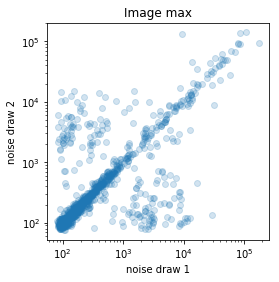

In [0]:
# Distribution of max before-after

plt.scatter((data[:,0].max(-1).max(-1)), data[:,1].max(-1).max(-1), alpha = 0.2)
plt.gca().set_aspect('equal')
plt.title('Image max')
plt.xlabel('noise draw 1')
plt.ylabel('noise draw 2')
plt.yscale('log')
plt.xscale('log')

In [0]:
# Look at the image pairs with the greatest difference in maxes

max_differences = np.abs((data[:,0].max(-1).max(-1)) - (data[:,1].max(-1).max(-1)))
top_max_differences = np.argsort(max_differences)[::-1][:50]

In [0]:
np.array(fnames)[top_max_differences]

array(['../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_32969.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_25955.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_71277.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_63006.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_37860.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_82498.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_26170.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_62460.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_73431.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_86795.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_21826.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_18556.fits.gz',
       '../gdrive/My Drive/N

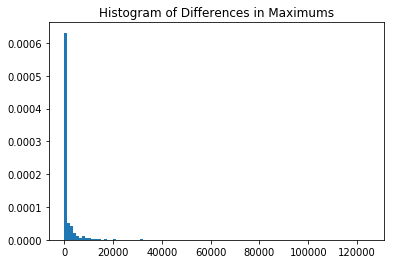

In [0]:
# Plot distribution of differences in maxes

plt.hist(max_differences, density=True, bins=100)
plt.title("Histogram of Differences in Maximums")
plt.show()

In [0]:
print(f'Median of max diffs: {np.median(max_differences)}')
print(f'Number of max differences less than 5000: {len(max_differences[max_differences < 5000])}')

Median of max diffs: 27.67591094970703
Number of max differences less than 5000: 925


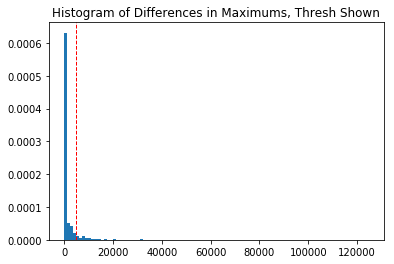

In [0]:
# Threshold of differences in image max

plt.hist(max_differences, density=True, bins=100)
plt.axvline(x=5000, color='r', linestyle='dashed', linewidth=1)
plt.title("Histogram of Differences in Maximums, Thresh Shown")
plt.show()

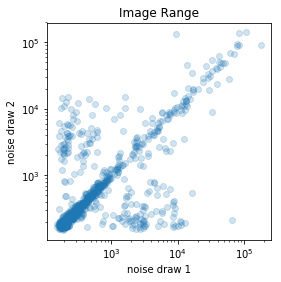

In [0]:
# Distribution of range before-after
plt.scatter((data[:,0].max(-1).max(-1) - data[:,0].min(-1).min(-1)), 
            (data[:,1].max(-1).max(-1) - data[:,1].min(-1).min(-1)), alpha = 0.2)
plt.gca().set_aspect('equal')
plt.title('Image Range')
plt.xlabel('noise draw 1')
plt.ylabel('noise draw 2')
plt.yscale('log')
plt.xscale('log')

In [0]:
# Look at the image pairs with the greatest difference in ranges

range_differences = np.abs((data[:,0].max(-1).max(-1) - data[:,0].min(-1).min(-1)) - (data[:,1].max(-1).max(-1) - data[:,1].min(-1).min(-1)))
top_range_differences = np.argsort(range_differences)[::-1][:50]

In [0]:
np.array(fnames)[top_range_differences]

array(['../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_32969.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_25955.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_26170.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_71277.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_63006.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_37860.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_82498.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_62460.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_73431.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_86795.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_21826.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_18556.fits.gz',
       '../gdrive/My Drive/N

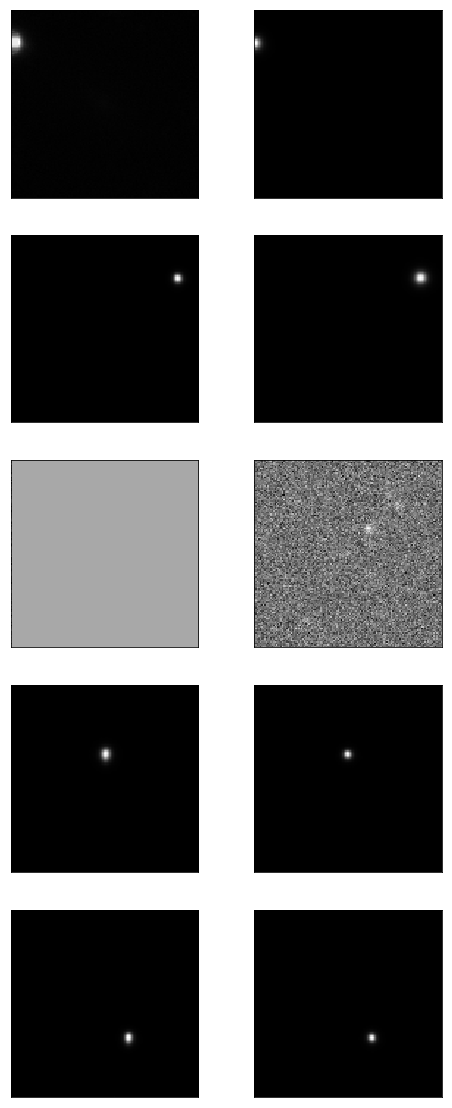

In [0]:
plot_grid(np.reshape(data[top_range_differences], (len(top_range_differences)*2, 128, 128)), 5, 2)

Text(0.5, 1.0, 'MSE between two noisy images')

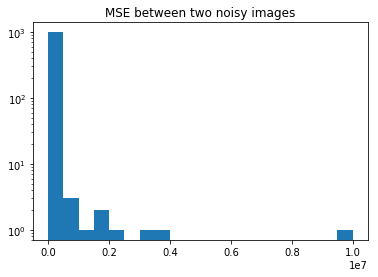

In [0]:
# Distribution of mse before-after
plt.hist(mse(data[:, 0], data[:, 1]), bins = 20)
plt.yscale('log')
plt.title('MSE between two noisy images')

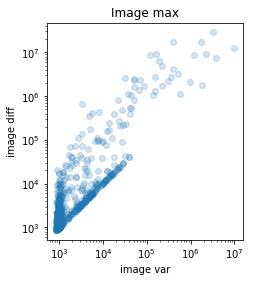

In [0]:
plt.scatter(mse(data[:, 0], data[:, 1]), mse(data[:,0], 0) + mse(data[:, 1], 0), alpha = 0.2)
plt.gca().set_aspect('equal')
plt.title('Image max')
plt.xlabel('image var')
plt.ylabel('image diff')
plt.yscale('log')
plt.xscale('log')

In [0]:
# Look at image pairs with the greatest mse 
relative_error = mse(data[:, 0], data[:, 1])/(mse(data[:,0], 0) + mse(data[:, 1], 0))
top_relative_errors = np.argsort(relative_error)[::-1][:5]

In [0]:
many_top_relative_errors = np.argsort(relative_error)[::-1][:27]

In [0]:
np.array(fnames)[many_top_relative_errors]

array(['../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_26798.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_27293.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_41400.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_08946.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_94571.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_83762.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_25972.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_49976.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_94516.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_95631.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_26170.fits.gz',
       '../gdrive/My Drive/Noise2Astro/cutouts_v1/balrog_cutouts_88341.fits.gz',
       '../gdrive/My Drive/N

Does not capture the loss outliers contained in this dataset

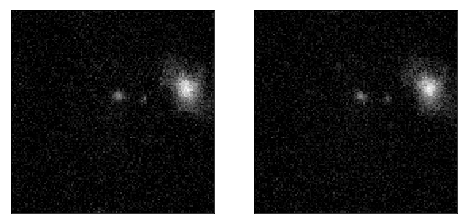

In [0]:
# A typical image pair
sample = data[100]
plot_images(sample, vmin = 0, vmax = sample.max())

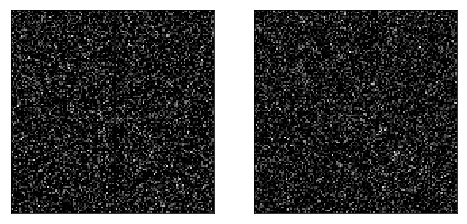

In [0]:
# A bad image pair
sample = data[top_relative_errors[3]]
plot_images(sample, vmin = 0, vmax = sample.max())

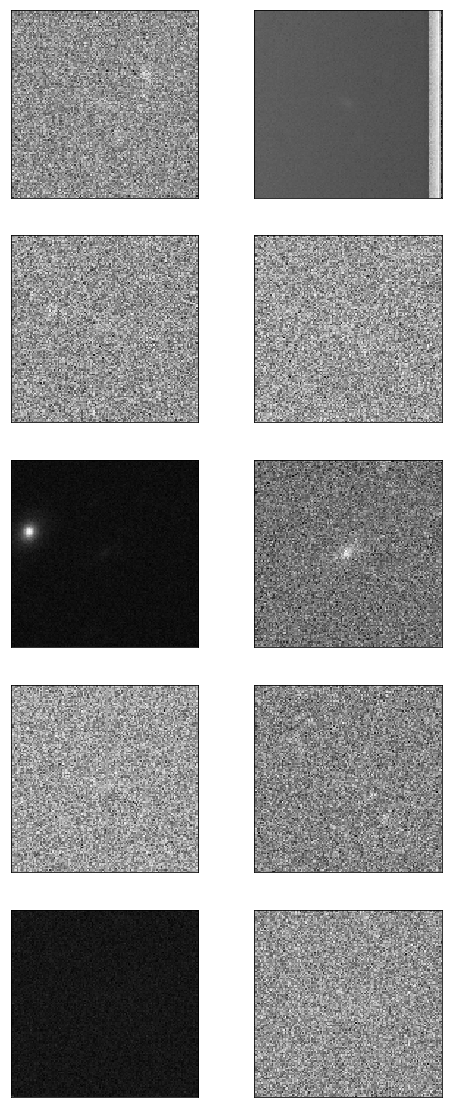

In [0]:
plot_grid(np.reshape(data[top_relative_errors], (len(top_relative_errors)*2, 128, 128)), 5, 2)

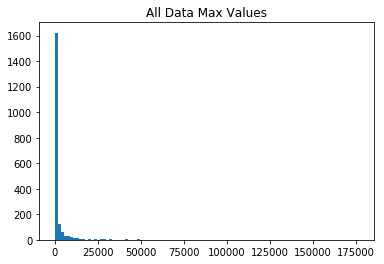

In [0]:
# Analyze the distribution of image maxes to find clamp threshold

all_data_maxs = np.concatenate([data[:, 0].max(-1).max(-1), data[:, 1].max(-1).max(-1)])
plt.title("All Data Max Values")
plt.hist(all_data_maxs, bins=100)
plt.show()

In [0]:
print(f'Median of Max Values: {np.median(all_data_maxs)}')
print(f'75th Percentile of Max Values: {np.percentile(all_data_maxs, 75)}')
print(f'80th Percentile of Max Values: {np.percentile(all_data_maxs, 80)}')

Median of Max Values: 222.8802490234375
75th Percentile of Max Values: 723.1699829101562
80th Percentile of Max Values: 1435.8170166015625


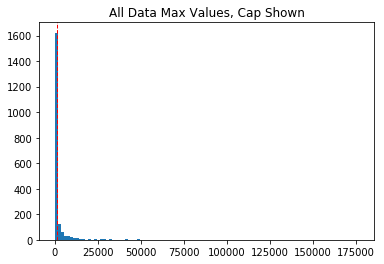

In [0]:
# Display clamp threshold

plt.axvline(x=1500, color='r', linestyle='dashed', linewidth=1)
plt.title("All Data Max Values, Cap Shown")
plt.hist(all_data_maxs, bins=100)
plt.show()

# Simulated Galaxy Data

Load in data

In [0]:
!pip install astropy

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from glob import glob
import os
from collections import defaultdict, Counter
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

In [0]:
fnames = glob("../gdrive/My Drive/Noise2Astro/cutouts_v1/*.gz")
fnames.sort()

In [8]:
from astropy.io import fits
print(len(fnames))

998


In [9]:
galaxies = {}
# Iterates over filenames to parse information
i = 0
for file in fnames:
    _, _, gal_id = os.path.splitext(os.path.basename(file))[0].split('_')
    gal_id = "gal_" + gal_id.replace('.fits', '')
    hdus = fits.open(file)
    imgs = hdus[0].data
    galaxies[gal_id] = imgs
    i += 1
    if i % 50 == 0:
      print(np.round(100*(i + .0)/len(fnames)), "% loaded.")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
5.0 % loaded.
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
10.0 % loaded.
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
15.0 % loaded.
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
20.0 % loaded.
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
25.0 % loaded.
251
252
253
254
255
256
257
258
25

In [0]:
# Joins image 0 and image 1 from each galaxy, cleans data
data = np.stack([(galaxies[gal_id][0], galaxies[gal_id][1]) for gal_id in galaxies])
data = clean_two_channel_data(data)
data = clamp_data(data)

In [0]:
# Normalizes by 255 factor. This is arbitrary, experiment with other number, or
# by not doing it
clipped_train_data = data[:700,:,:128,:128]/255
clipped_val_data = data[700:825,:,:128,:128]/255
clipped_test_data = data[825:,:,:128,:128]/255

In [5]:
from models.babyunet import BabyUnet
from models.dncnn import DnCNN
from models.dnfcn8 import DnFCN8
from models.singleconv import SingleConvolution

from util import getbestgpu
# device = getbestgpu()
device = 'cuda'
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch

ModuleNotFoundError: ignored

Choose model and loss function, set hyperparameters

In [0]:
#model = BabyUnet()
#model = DnCNN(1)
#model = SingleConvolution()
model = DnFCN8
model.to(device)
loss_function = MSELoss()
#loss_function = L1Loss()
optimizer = Adam(model.parameters(), lr=0.00005)

train_loader = DataLoader(clipped_train_data, batch_size=5, shuffle=False)
val_loader = DataLoader(clipped_val_data, batch_size=5, shuffle=False)
test_loader = DataLoader(clipped_test_data, batch_size=5, shuffle=False)

train_hist = defaultdict(list)
val_hist = defaultdict(list)
test_hist = defaultdict(list)

Main training loop

In [165]:
n_epochs = 1000
best_loss = 100000

# Keeps track of losses
train_losses = []
val_losses = []

best_model={}

for epoch in range(n_epochs):
  
    train_loss = 0
    for i, batch in enumerate(train_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)
        train_hist[i].append(loss.cpu().item())

        train_loss += loss.cpu().item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
    train_losses.append(train_loss/len(train_loader))
    # Keeps track of loss over 10 epochs
    if epoch % 10 == 0:
        print("Loss (", epoch, "): \t", round(loss.item(), 4))
        
    val_loss = 0
    for i, batch in enumerate(val_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2) 
        val_hist[i].append(loss.cpu().item())
        val_loss += loss.cpu().item()
        
    val_losses.append(val_loss/len(val_loader))
    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model.state_dict()
        
        
    optimizer.zero_grad()
    
torch.save(best_model, '../gdrive/My Drive/Noise2Astro/two_channel_DnFCN8_model')


0
Loss ( 0 ): 	 0.0149
1
2
3
4
5
6
7
8
9
10
Loss ( 10 ): 	 0.0044
11
12
13
14
15
16
17
18
19
20
Loss ( 20 ): 	 0.004
21
22
23
24
25
26
27
28
29
30
Loss ( 30 ): 	 0.0043
31
32
33
34
35
36
37
38
39
40
Loss ( 40 ): 	 0.0035
41
42
43
44
45
46
47
48
49


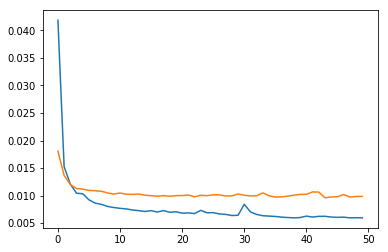

In [166]:
# Plot losses
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)

Train Final Losses
Final Train Losses Mean: 0.006169385444705508
Final Train Losses Median: 0.004357232712209225
75th Percentile Train Loss: 0.0077387928031384945


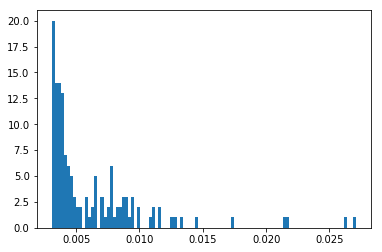

In [87]:
# Analyze distribution of the train losses on the final epoch

print("Train Final Losses")
final_losses = []
for losses in train_hist.values():
    final_losses.append(losses[-1])
    
plt.figure()
plt.hist(final_losses, bins=100)
final_losses=np.array(final_losses)

print(f'Final Train Losses Mean: {np.mean(final_losses)}')
print(f'Final Train Losses Median: {np.median(final_losses)}')
print(f'75th Percentile Train Loss: {np.percentile(final_losses, 75)}')

Validation Final Losses
Final Val Losses Mean: 0.009455421632155776
Final Val Losses Median: 0.007037075702100992
75th Percentile Val Loss: 0.009629863314330578


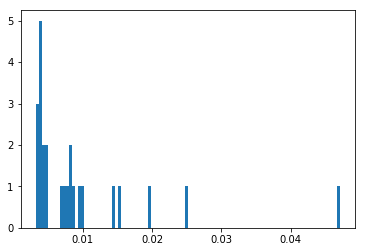

In [88]:
# Analyze distribution of the validation losses on the final epoch

print("Validation Final Losses")
final_losses = []
for losses in val_hist.values():
    final_losses.append(losses[-1])
    
plt.figure()
plt.hist(final_losses, bins=100)
final_losses=np.array(final_losses)

print(f'Final Val Losses Mean: {np.mean(final_losses)}')
print(f'Final Val Losses Median: {np.median(final_losses)}')
print(f'75th Percentile Val Loss: {np.percentile(final_losses, 75)}')

In [172]:
# Compute Test Loss
test_loss = 0
model.load_state_dict(best_model, strict=False)
for i, batch in enumerate(test_loader):
    batch = batch.to(torch.float)
    noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
    noisy_images_1 = noisy_images_1.to(device)
    noisy_images_2 = noisy_images_2.to(device)

    net_output = model(noisy_images_1)

    loss = loss_function(net_output, noisy_images_2)  
    test_hist[i].append(loss.cpu().item())
    test_loss += loss

print(f'Mean Test Loss: {test_loss/len(test_loader)}')
        
i, test_batch = next(enumerate(test_loader))
test_batch = test_batch.to(torch.float)
noisy_images_1, noisy_images_2 = test_batch[:,0:1], test_batch[:,1:2]
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

RuntimeError: ignored

Test Losses
Final Test Losses Median: 0.004219132708385587
75th Percentile Test Loss: 0.0052920179441571236


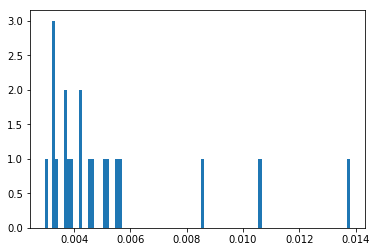

In [90]:
# Analyze distribution of test losses

print("Test Losses")
final_losses = []
for losses in test_hist.values():
    final_losses.append(losses[-1])
    
plt.figure()
plt.hist(final_losses, bins=100)
final_losses=np.array(final_losses)
print(f'Final Test Losses Median: {np.median(final_losses)}')
print(f'75th Percentile Test Loss: {np.percentile(final_losses, 75)}')

Plot some example images

In [173]:
# Predicts noisy image 2 from noisy image 1, denoising the image
# Same as what is done in Training section above
output = model(noisy_images_1.to(device))
idx = 0

plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"],
            vmax=output[idx].cpu().detach().numpy().max(-1).max(-1), vmin=0)

RuntimeError: ignored

[0.38206312]


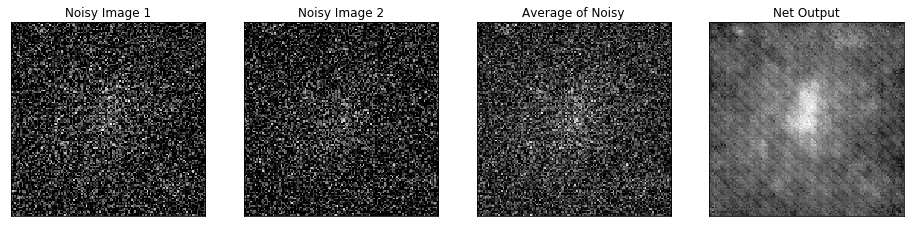

In [171]:
idx = 2
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

print(noisy_images_1[idx].cpu().detach().numpy().max(-1).max(-1))

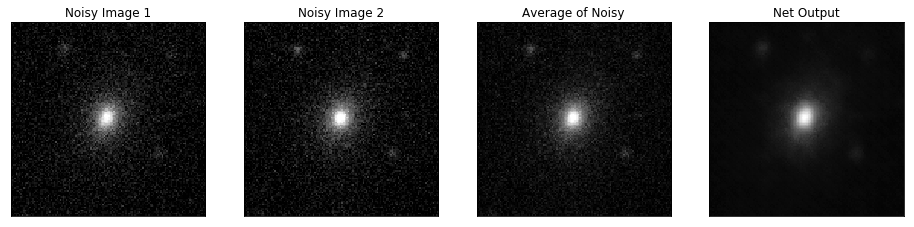

In [169]:
idx = 3
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"],
            vmax=output[idx].cpu().detach().numpy().max(-1).max(-1), vmin=0)

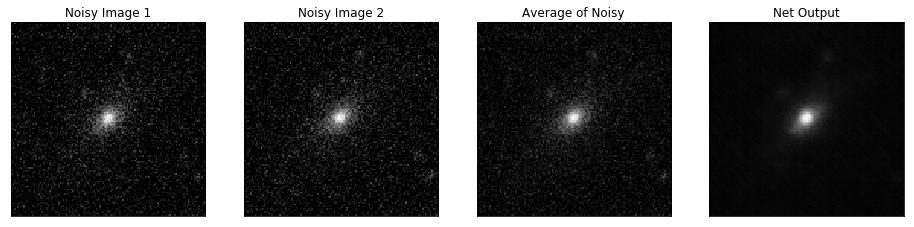

In [170]:
idx = 4
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

# Three-Channel Data

Import data

In [0]:
!pip install astropy

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from glob import glob
import os
from collections import defaultdict, Counter
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from astropy.io import fits
from torch import Tensor
import math

The three channel dataset abstraction randomly selects 2 channels to make a pair of images to train on. This increases the dataset size by a factor of three. 

In [0]:
# .8/.1/.1 Train/Val/Test Split, could just change this split below.
# Might be useful to make this an argument

class ThreeChannelGalaxyDataset(Dataset):
  """MultiChannel Dataset"""
  
  def __init__(self, type):
    self.fnames = glob("../gdrive/My Drive/Noise2Astro/cutouts_v1/*.gz")
    self.files_length = len(self.fnames)
    
    self.train_len = math.floor(self.files_length * .8)
    self.val_len = math.floor(self.files_length * .1)
    self.test_len = math.floor(self.files_length * .1)
    
    self.data = self._load_data(type)
    self.data = self._clean()
    self.type = type
    
    
  def __len__(self):
    return len(self.data)
  
  
  def _load_data(self, type):
    galaxies = []
    if type == "train":
      for i in range(self.train_len):
        galaxies.append(fits.open(self.fnames[i])[0].data[:3])
        if i % 50 == 0:
          print(f'{i/self.train_len} Done')
    
    elif type == "validate":
      for i in range(self.train_len, self.train_len + self.val_len):
        galaxies.append(fits.open(self.fnames[i])[0].data[:3])
        if i % 50 == 0:
          print(f'{(i - self.train_len)/self.val_len} Done')

    elif type == "test":
      for i in range(self.train_len + self.val_len, self.train_len +
                     self.val_len + self.test_len):
        galaxies.append(fits.open(self.fnames[i])[0].data[:3])
        if i % 50 == 0:
          print(f'{(i - (self.train_len + self.val_len))/self.test_len} Done')

    galaxies = np.stack(galaxies)
    return galaxies
  
  
  def _clean(self):
    return clamp_data(clean_three_channel_data(self.data))
  
  
  def __getitem__(self, idx):
    channels = self.data[idx]
    idx1 = np.random.randint(0, 3)
    idx2 = idx1
    while idx2 == idx1:
      idx2 = np.random.randint(0, 3)
      
    pair = np.stack([channels[idx1], channels[idx2]])
    
    return np.array(pair[:,:128,:128]/255)
  
  
  def get_full_batch(self, idx):
    return self.data[idx]  

In [0]:
train_data = ThreeChannelGalaxyDataset("train")
val_data = ThreeChannelGalaxyDataset("validate")
test_data = ThreeChannelGalaxyDataset("test")

0.0 Done
0.12531328320802004 Done
0.2506265664160401 Done
0.37593984962406013 Done
0.5012531328320802 Done
0.6265664160401002 Done
0.7518796992481203 Done
0.8771929824561403 Done
(399, 3, 128, 128)
(3, 399)
(399,)
0.1111111111111111 Done
(9, 3, 128, 128)
(3, 9)
(9,)
(9, 3, 128, 128)
(3, 9)
(9,)


In [0]:
from models.babyunet import BabyUnet
from models.dncnn import DnCNN
from models.dnfcn8 import DnFCN8
from models.singleconv import SingleConvolution
from util import getbestgpu
# device = getbestgpu()
device = 'cuda'
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch

Set up model, loss function, hyperparameters

In [0]:
#model = BabyUnet()
#model = DnCNN(1)
#model = DnFCN8()
model = SingleConvolution()
model.to(device)
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr= .00005)

train_loader = DataLoader(train_data, batch_size=9, shuffle=False)
val_loader = DataLoader(val_data, batch_size=9, shuffle=False)
test_loader = DataLoader(test_data, batch_size=9, shuffle=False)

Main training loop

In [0]:
n_epochs = 1200
best_loss = 100000

# Keeps track of losses
train_losses = []
val_losses = []

best_model={}

for epoch in range(n_epochs):
  
    train_loss = 0
    for i, batch in enumerate(train_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:, 0:1], batch[:, 1:2]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)
        train_loss += loss.cpu().item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
    train_losses.append(train_loss/len(train_loader))
    # Keeps track of loss over 10 epochs
    if epoch % 10 == 0:
        print("Loss (", epoch, "): \t", round(train_loss/len(train_loader), 4))
        
    val_loss = 0
    for i, batch in enumerate(val_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:, 0:1], batch[:, 1:2]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)  
        val_loss += loss.cpu().item()
        
    val_losses.append(val_loss/len(val_loader))
    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model.state_dict()
          
    optimizer.zero_grad()

Loss ( 0 ): 	 0.0575
Loss ( 10 ): 	 0.0521
Loss ( 20 ): 	 0.047
Loss ( 30 ): 	 0.0378
Loss ( 40 ): 	 0.0379
Loss ( 50 ): 	 0.029
Loss ( 60 ): 	 0.0264
Loss ( 70 ): 	 0.0244
Loss ( 80 ): 	 0.0237
Loss ( 90 ): 	 0.0213
Loss ( 100 ): 	 0.0205
Loss ( 110 ): 	 0.0191
Loss ( 120 ): 	 0.0161
Loss ( 130 ): 	 0.0181
Loss ( 140 ): 	 0.0136
Loss ( 150 ): 	 0.0161
Loss ( 160 ): 	 0.0156
Loss ( 170 ): 	 0.0151
Loss ( 180 ): 	 0.0168
Loss ( 190 ): 	 0.0158
Loss ( 200 ): 	 0.0154
Loss ( 210 ): 	 0.0144
Loss ( 220 ): 	 0.0137
Loss ( 230 ): 	 0.0181
Loss ( 240 ): 	 0.0147
Loss ( 250 ): 	 0.0153
Loss ( 260 ): 	 0.0189
Loss ( 270 ): 	 0.0149
Loss ( 280 ): 	 0.0161
Loss ( 290 ): 	 0.0126
Loss ( 300 ): 	 0.0157
Loss ( 310 ): 	 0.0141
Loss ( 320 ): 	 0.014
Loss ( 330 ): 	 0.0147
Loss ( 340 ): 	 0.0168
Loss ( 350 ): 	 0.0162
Loss ( 360 ): 	 0.0161
Loss ( 370 ): 	 0.0158
Loss ( 380 ): 	 0.012
Loss ( 390 ): 	 0.0148
Loss ( 400 ): 	 0.0131
Loss ( 410 ): 	 0.0154
Loss ( 420 ): 	 0.0137
Loss ( 430 ): 	 0.0132
Los

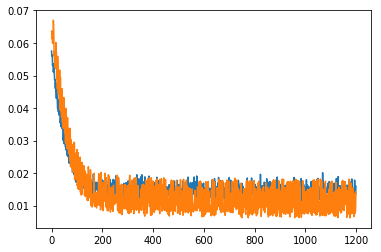

In [0]:
# Plot losses
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)

In [0]:
# Generate Test Loss

test_loss = 0
model.load_state_dict(best_model, strict=False)
for i, batch in enumerate(test_loader):
    batch = batch.to(torch.float)
    noisy_images_1, noisy_images_2 = batch[:, 0:1], batch[:, 1:2]
    noisy_images_1 = noisy_images_1.to(device)
    noisy_images_2 = noisy_images_2.to(device)

    net_output = model(noisy_images_1)
    loss = loss_function(net_output, noisy_images_2)  
    test_loss += loss

print(f'Test Loss: {test_loss/len(test_loader)}')

Test Loss: 5.018847942352295


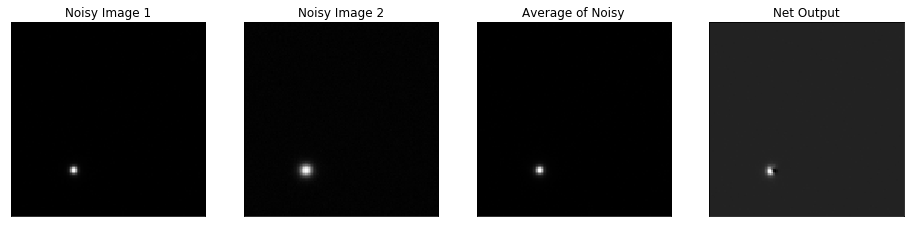

In [0]:
# Another way to check out some test images, probably better

test_loss = 0
model.load_state_dict(best_model, strict=False)
for i, batch in enumerate(test_loader):
  if i == 5:
    batch = batch.to(torch.float)
    noisy_images_1, noisy_images_2 = batch[:, 0:1], batch[:, 1:2]
    noisy_images_1 = noisy_images_1.to(device)
    noisy_images_2 = noisy_images_2.to(device)

    output = model(noisy_images_1)
    plot_tensors([noisy_images_1,
                  noisy_images_2,
                  0.5*(noisy_images_1 + noisy_images_2),
                  output],
                ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

Add in distributions of losses, as in the above section, if desired